In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error as mse
import math
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers

Using TensorFlow backend.


# General Code

### Plotting

In [2]:
def plot_decision_boundary(X,W,t):
    #plot classes
    plt.scatter(X[0,:], X[1,:], c=t[0,:])
    
    #plot line
    x = [-5,5]
    y = [line(x[0],W), line(x[1],W)]
    plt.plot(x, y)
    plt.ylim(-3, 3)
    plt.xlim(-3,3)
    plt.show()
    
def line(x,W):
    k = -(W.T[0]/W.T[1])
    m = -W.T[2]/W.T[1]
    return k*x+m

def plot_bell(x,y,z):
    xx, yy = np.meshgrid(x,y)
    print(xx.shape)
    print(z.shape)
    zz = z.reshape(xx.shape)

    #plot.axis([-5 5 -5 5 -0.7 0.7])
    plt.contourf(xx, yy, zz, cmap=plt.cm.Spectral)
    plt.show()

### Generating

In [3]:
def gen_binary(n = 100, bias = True):
    mA = [1.2, 0.7]
    mB = [-1.5, 0.0]
    sigmaA = 0.4
    sigmaB = 0.35
    
    classA1 = np.random.normal(mA[0],sigmaA,n) 
    classA2 = np.random.normal(mA[1],sigmaA,n)
    classA = np.vstack((classA1,classA2))
    labelA = np.ones((1,n))
    
    classB1 = np.random.normal(mB[0],sigmaB,n)
    classB2 = np.random.normal(mB[1],sigmaB,n)
    classB = np.vstack((classB1,classB2))
    labelB = -np.ones((1,n))
    
    data = np.hstack((classA,classB))
    labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,2*n])
    t = np.zeros([1,2*n])
    index = np.random.permutation(2*n)
    
    for i in index:
        X[:2,i] = data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = labels[0,index[i]]
    
    return X, t


def gen_nonlin_sep(n = 100, bias = True, subsample_method = 0):
    
    mA = [1.0, 0.3]
    mB = [0.0, -0.1]
    sigmaA = 0.2
    sigmaB = 0.3
    
    classA1 = np.hstack((np.random.normal(-mA[0],sigmaA,math.floor(n/2)), \
                        np.random.normal(mA[0],sigmaA,math.floor(n/2))))
    classA2 = np.random.normal(mA[1],sigmaA,n)
    classA = np.vstack((classA1,classA2))
    labelA = np.ones((1,n))
      
    classB1 = np.random.normal(mB[0],sigmaB,n)
    classB2 = np.random.normal(mB[1],sigmaB,n)
    classB = np.vstack((classB1,classB2))
    labelB = -np.ones((1,n))
    
    data = np.hstack((classA,classB))
    labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,2*n])
    t = np.zeros([1,2*n])
    index = np.random.permutation(2*n)
    
    for i in index:
        X[:2,i] = data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = labels[0,index[i]]
    
    return X, t

def gen_W(X):
    W = np.random.normal(0, 1, (1, X.shape[0]))
    
    #bias
    if X[2,0] == 0:
        W.T[2] = 0
        
    return W

def gen_encoder(n = 100):
    X = -np.ones((8, n))
    
    #randomly make something 1 
    idx = np.random.randint(7, size=n)
    for i in range(X.shape[1]):
        X[idx[i],i] = 1

    return X

# Matlab code
# x=[-5:0.5:5]’;
# y=[-5:0.5:5]’;
# z=exp(-x.*x*0.1) * exp(-y.*y*0.1)’ - 0.5;
# mesh(x, y, z);
def gen_bell(step = .5):
    x = np.arange(-5, 5, step)
    y = np.arange(-5, 5, step)
    
    #turn into columns since T does nothing?
    x = np.reshape(x, (x.shape[0],1))
    y = np.reshape(y, (y.shape[0],1))
    
    xx, yy = np.meshgrid(x, y)
    z = np.dot(np.exp(-x * x * 0.1), np.exp(-y * y * 0.1).T) - 0.5
    
    grid_X =  np.vstack((xx.ravel(), yy.ravel()))

    grid_Y = [z.ravel()]
    return grid_X, grid_Y, x, y

    
    

# Subsampling

In [4]:
def subsample_data(data, labels, method = 1, bias = 1):
    '''
    Returns a properly subsampled dataset according to
    the method specified by the user.
    
    Subsample methods:
    1 = random 25% from each class
    2 = random 50% from class A
    3 = random 50% from class B
    4 = 20% from left A and 80% from right A
    '''
    data_dim = data.shape[0]
    n = int(data.shape[1]/2)
    
    classA = np.zeros([data_dim, n])
    classB = np.zeros([data_dim, n])
    countA = 0
    countB = 0
    
    for i in range(0,2*n):
        if labels[:,i] == 1:
            classA[:,countA] = data[:,i]
            countA += 1
        else:
            classB[:,countB] = data[:,i]
            countB += 1
            
    if method == 1:
        classA = classA[:,0:math.floor(0.75*n)]
        labelA = np.ones((1,math.floor(0.75*n)))
        
        classB = classB[:,0:math.floor(0.75*n)]
        labelB = -np.ones((1,math.floor(0.75*n)))        
        
    elif method == 2:
        classA = classA[:,0:math.floor(n/2)]
        labelA = np.ones((1,math.floor(n/2)))
        labelB = -np.ones((1,n))
    
    elif method == 3:
        classB = classB[:,0:math.floor(n/2)]
        labelB = -np.ones((1,math.floor(n/2)))
        labelA = np.ones((1,n))
    
    elif method == 4:
        classA1 = np.zeros([data_dim, math.floor(n/2)])
        classA2 = np.zeros([data_dim, math.floor(n/2)])
        countA1 = 0
        countA2 = 0
        
        for i in range(0,n):
            if classA[0,i] < 0:
                classA1[:,countA1] = classA[:,i]
                countA1 += 1
            else:
                classA2[:,countA2] = classA[:,i]
                countA2 += 1
        
        classA1 = classA1[:,0:math.floor(0.8*math.floor(n/2))]
        classA2 = classA2[:,0:math.floor(0.2*math.floor(n/2))]
        classA = np.hstack((classA1,classA2))
        labelA = np.ones((1,math.floor(n/2)))
        labelB = -np.ones((1,n))
    
    new_data = np.hstack((classA,classB))
    new_labels = np.hstack((labelA,labelB))
    
    #shuffle and add bias
    X = np.zeros([3,math.floor(1.5*n)])
    t = np.zeros([1,math.floor(1.5*n)])
    index = np.random.permutation(math.floor(1.5*n))
    
    for i in index:
        X[:2,i] = new_data[:2, index[i]]
        
        if bias:
            X[2,i] = 1
            
        t[0,i] = new_labels[0,index[i]]

    return X, t        
    
            

# Perceptron

In [5]:
def prediction(data, weight):
    activation = weight[len(data)-1]
    for i in range(len(data)-1):
        activation += weight[i]*data[i]
    if activation >=0:
        return 1.0
    else :
        return -1.0
    
def weight_update_perceptron(dataset, labels, lr, n_epoch):
    weights = np.zeros(len(dataset[0]))
    print('l = ',len(dataset[0]))
    for epoch in range(n_epoch):
        sum_error = 0.0
        for i in range(len(dataset)-1):
            data = dataset[:,i]
            p = prediction(data, weights)
            error = (labels[:,i] - p)/2
            sum_error += abs(error)
            #weights[len(data)-1] = weights[len(data)-1] + (lr* error)
            for j in range(len(data)-1):
                weights[j] = weights[j] + (lr*error*data[j])
        #print('epoch=%d, lr=%.3f, error=%.3f' % (epoch, lr, sum_error))
    return weights

#dataset, labels = gen_binary(5)
#dataset = np.transpose(dataset)
#w = weight_update_perceptron(dataset, labels, 0.1, 10)
#print("w = ", w)

# Delta Rule

In [6]:
def delta(W, x, t, eta):
    inner = np.dot(W,x) - t
    return eta * np.dot(inner, np.transpose(x))

def run_delta(W, X, T, eta, n_epochs):
    Wnew = W[:]
    for e in range(n_epochs):
        for i in range(X.shape[1]):
            x = X[:,i,None]
            t = T[:,i]
            Wnew = Wnew - delta(Wnew,x,t,eta)
    return Wnew

def run_delta_batch(W, X, T, eta, n_epochs):
    Wnew = W[:]
    for e in range(n_epochs):
        Wnew = Wnew - eta*np.dot((np.dot(Wnew,X)-T),X.T)
    return Wnew


# Run Classifier

In [7]:
def run_evaluation(W, X, T):
    Y = np.dot(W, X)
    Y[Y > 0] = 1
    Y[Y < 0] = -1
    P = (Y==T)
    TrueA = np.logical_and((Y==1),(T==1)) 
    TotalA = (T==1)
    TrueB =  np.logical_and((Y==-1),(T==-1))
    TotalB = (T==-1)    
    print("Classification accuracy =",np.sum(P)/P.shape[1]*100,"\b%.")
    print("Accuracy of A class predictions =",np.sum(TrueA)/np.sum(TotalA)*100,"\b%")
    print("Accuracy of B class predictions =",np.sum(TrueB)/np.sum(TotalB)*100,"\b%")


# Experiments on Linearly Separable Data

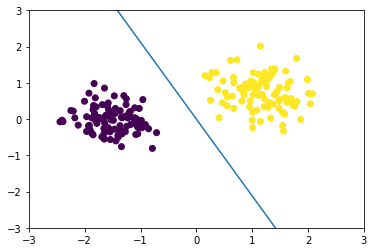

Classification accuracy = 100.0 %.
Accuracy of A class predictions = 100.0 %
Accuracy of B class predictions = 100.0 %


In [8]:
X, T = gen_binary(100, False)
W = gen_W(X)

#W1 = run_delta(W,X,T,0.001,100)
#plot_decision_boundary(X,W1,T)

W2 = run_delta_batch(W,X,T,0.001,1000)
plot_decision_boundary(X,W2,T)
run_evaluation(W2, X, T)

#W3 = weight_update_perceptron(X, T, 0.001, 10000)
#plot_decision_boundary(X,W3,T)


# Experiments on Non-Linearly Separable Data

In [9]:
X, T = gen_nonlin_sep()

Classification accuracy = 79.33333333333333 %.
Accuracy of A class predictions = 84.0 %
Accuracy of B class predictions = 74.66666666666667 %


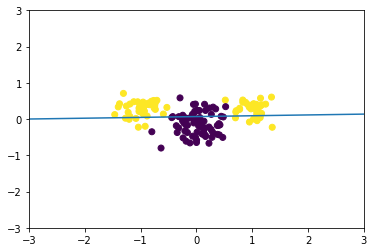

Classification accuracy = 78.0 %.
Accuracy of A class predictions = 83.0 %
Accuracy of B class predictions = 73.0 %


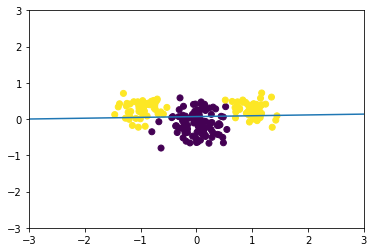

In [10]:
Xsub1, Tsub1 = subsample_data(X,T,1)
W = gen_W(Xsub1)

W0 = run_delta_batch(W,Xsub1,Tsub1,0.001,100)
run_evaluation(W0, Xsub1, Tsub1)
plot_decision_boundary(Xsub1,W0,Tsub1)
run_evaluation(W0, X, T)
plot_decision_boundary(X,W0,T)


## Two-Layer Perceptron

In [11]:
def sigmoid(z):
    return (1/(1+np.exp(-z)))

def der_sigmoid(z):
    l = sigmoid(z)
    return (l*(1-l))

# 2 layer perceptron
# x in features X samples; y is 1 X samples
# W and b are initialized accordingly 
class two_layer_perceptron:
    def __init__(self, x, y, output_dim = 1):
        self.X=x
        self.Y=y
        self.Layers=2
        self.nodes_hidden_layer = 3
        self.output_dim = output_dim
        self.dims = [x.shape[0], self.nodes_hidden_layer, output_dim]
        self.W = self.init_W()
        self.momentum = [np.zeros(self.W[0].shape), np.zeros(self.W[1].shape)]
        self.alpha = 0.9
        self.lr = 0.1
        self.loss = []
        self.steps = []
        
        #configuration 
        self.use_batch = True
        self.use_momentum = True
    
    def init_W(self):
        return [np.random.normal(0, 1, (self.nodes_hidden_layer, self.X.shape[0] + 1)),
        np.random.normal(0, 1, (self.output_dim, self.nodes_hidden_layer + 1))]  
            
    def nloss(self,Yh):
        loss = np.sum((self.Y - Yh)**2/2 ) 
        return loss
    
    
    # Matlab Code
    # hin = w * [patterns ; ones(1,ndata)];
    # hout = [2 ./ (1+exp(-hin)) - 1 ; ones(1,ndata)];
    # oin = v * hout;
    # out = 2 ./ (1+exp(-oin)) - 1;
    def forward(self, inputs):
        bias =  np.ones((1, inputs.shape[1]))
        Xb = np.concatenate((inputs,bias)) #add bias   
        
        hin = np.dot(self.W[0], Xb)
        hmid = (2 / (1+np.exp(-hin))) - 1
        hout = np.concatenate((hmid, bias)) #add bias
        
        oin = np.dot(self.W[1], hout)
        out = (2 / (1+np.exp(-oin))) - 1
        
        return hout, out
    
    # Matlab Code 
    # delta_o = (out - targets) .* ((1 + out) .* (1 - out)) * 0.5;
    # delta_h = (v’ * delta_o) .* ((1 + hout) .* (1 - hout)) * 0.5;
    # delta_h = delta_h(1:Nhidden, :);
    def backward(self, O, H):           
        delta_o = (O - self.Y) * ((1 + O) * (1 - O)) * 0.5
        delta_h = np.dot(self.W[1].T, delta_o) * ((1 + H) * (1 - H)) * 0.5
        delta_hf = delta_h[:-1,:]
        
        return delta_hf, delta_o

    
    # Matlab Code
    # dw = (dw .* alpha) - (delta_h * pat’) .* (1-alpha);
    # dv = (dv .* alpha) - (delta_o * hout’) .* (1-alpha);
    # W = w + dw .* eta;
    # V = v + dv .* eta;
    def update_weights(self, H, delta_o, delta_h):
        #add bias for shape stuff
        bias = np.ones((1, self.X.shape[1]))
        Xb = np.concatenate((self.X,bias))
        
        if self.use_momentum:
            self.momentum[0] = (self.momentum[0] * self.alpha) - np.dot(delta_h, Xb.T) * (1 - self.alpha)
            self.momentum[1] = (self.momentum[1] * self.alpha) - np.dot(delta_o, H.T) * (1 - self.alpha)
            self.W[0] += self.momentum[0] * self.lr
            self.W[1] += self.momentum[1] * self.lr
        else:
            self.W[0] += -self.lr * np.dot(delta_h, Xb.T)
            self.W[1] = -self.lr * np.dot(delta_o, H.T)
    
    def predict(self, inputs, do_classification = True):
        _, O = self.forward(inputs)
        
        if do_classification:
            O[O > 0] = 1
            O[O <= 0] = -1
        return O
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
        
        for i in range(0, iter):
            if(self.use_batch):
                H,O = self.forward(self.X)
                delta_h, delta_o = self.backward(O,H)
                self.update_weights(H, delta_o, delta_h)
                
            else:
                print("NOT IMPLENETED")

            if i % 500 == 0:
                loss = self.nloss(O)
                print ("Cost after iteration ",i,"  = ", loss,"\n")
                self.loss.append(loss)
                self.steps.append(i)
                if(loss < 1e-3):
                    break
    
    def plot_decision_boundary(self, points = True, h = 0.1):
        x_min, x_max = self.X[0, :].min() - 1, self.X[0, :].max() + 1
        y_min, y_max = self.X[1, :].min() - 1, self.X[1, :].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        grid_data = np.transpose(np.c_[xx.ravel(), yy.ravel()])
        ones = np.transpose(np.ones((np.shape(xx)[1]*np.shape(xx)[0],1)))
        grid_data = np.vstack((grid_data,ones))
        Z = self.predict(grid_data)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        if points:
            plt.scatter(self.X[0, :], self.X[1, :], c = self.Y[0])
        plt.show()
        
    def plot_bell_approximation(self, grid_X,x,y):
        result = self.predict(grid_X, do_classification=False)
        xx, yy = np.meshgrid(x,y)
        zz = result.reshape(xx.shape)

        #plot.axis([-5 5 -5 5 -0.7 0.7])
        plt.contourf(xx, yy, zz, cmap=plt.cm.Spectral)
        plt.show()

x dim =  (3, 600)
y dim  =  1 600
Cost after iteration  0   =  357.2734707328418 

Cost after iteration  500   =  9.21302914092433e-09 



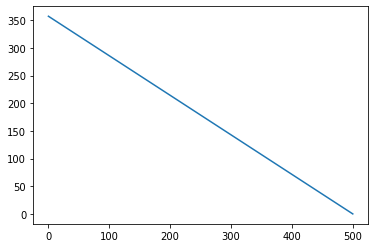

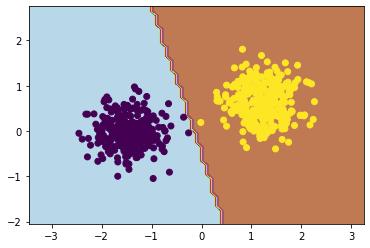

In [12]:
x,y = gen_binary(300)   
print("x dim = ", x.shape)
print("y dim  = ", len(y),len(y[0]))
nn = two_layer_perceptron(x,y)
nn.gd(x, y, iter = 1000)
plt.plot(nn.steps,nn.loss)
plt.show()
nn.plot_decision_boundary()


## Encoder

Cost after iteration  0   =  12.734774416527227 

Cost after iteration  500   =  0.044962105126727235 



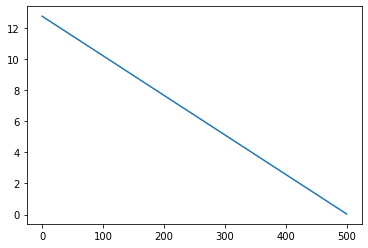

In [13]:
x = gen_encoder(3)
y = x.copy()
nn = two_layer_perceptron(x,y,8)
nn.gd(x, y, iter = 1000)

plt.plot(nn.steps,nn.loss)
plt.show()

## Function Approximation

Cost after iteration  0   =  161.3980465872306 

Cost after iteration  500   =  0.4967638989029961 



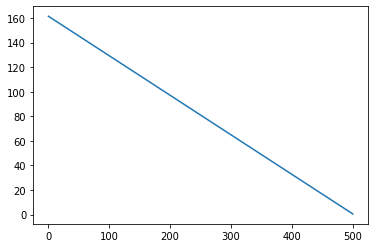

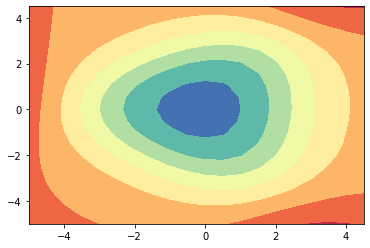

(20, 20)
(1, 400)


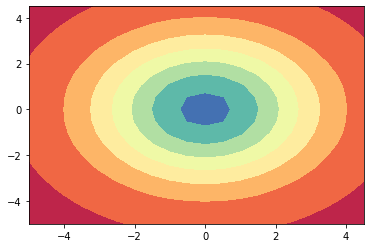

In [14]:
grid_X, grid_Y, x, y = gen_bell()
nn = two_layer_perceptron(grid_X, grid_Y, 1)
nn.gd(grid_X, grid_Y, iter = 1000)

plt.plot(nn.steps,nn.loss)
plt.show()
nn.plot_bell_approximation(grid_X,x,y)
plot_bell(x,y,np.array(grid_Y))

## Storage

In [15]:
# def sigmoid(z):
#     return (1/(1+np.exp(-z)))

# def der_sigmoid(z):
#     l = sigmoid(z)
#     return (l*(1-l))

# # 2 layer perceptron
# # x in features X samples; y is 1 X samples
# # W and b are initialized accordingly 
# class two_layer_perceptron:
#     def __init__(self, x, y, output_dim = 1):
#         self.X=x
#         self.Y=y
#         self.Yh=np.zeros((1,self.Y.shape[1]))
#         self.Layers=2
#         self.nodes_hidden_layer = 3
#         self.dims = [x.shape[0], self.nodes_hidden_layer, output_dim]
#         print(self.dims)
#         self.params = {}
#         self.ch = {}
#         self.grad = {}
#         self.loss = []
#         self.lr=0.1
#         self.momentum = 0.9
#         self.samples = self.Y.shape[1]
#     def initialize_params(self):
#         self.params['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
#         self.params['b1'] = np.zeros((self.dims[1], 1))        
#         self.params['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
#         self.params['b2'] = np.zeros((self.dims[2], 1))                
#         return

#     def nloss(self,Yh):
#         loss = np.sum(abs(self.Y - Yh)/2 ) 
#         return loss

#     def forward(self):
#         Z1 = self.params['W1'].dot(self.X) + self.params['b1'] 
#         A1 = sigmoid(Z1)
#         self.ch['Z1'],self.ch['A1']=Z1,A1
#         Z2 = self.params['W2'].dot(A1) + self.params['b2']  
#         A2 = sigmoid(Z2)
#         self.ch['Z2'],self.ch['A2']=Z2,A2
#         self.Yh=A2
#         loss=self.nloss(A2)
#         return self.Yh, loss
# #             return self.Yh

#     def backward(self):               
#         dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))
#         dLoss_Z2 = dLoss_Yh * der_sigmoid(self.ch['Z2'])    
#         dLoss_A1 = np.dot(self.params["W2"].T,dLoss_Z2)
#         dLoss_W2 = (1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T))*(1-self.momentum)
#         dLoss_W2 += self.momentum*dLoss_W2
#         dLoss_b2 = (1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])))*(1-self.momentum)
#         dLoss_b2 += self.momentum*dLoss_b2

#         dLoss_Z1 = dLoss_A1 * der_sigmoid(self.ch['Z1'])        
#         dLoss_A0 = np.dot(self.params["W1"].T,dLoss_Z1)
#         dLoss_W1 = (1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T))*(1-self.momentum)
#         dLoss_W1 += self.momentum*dLoss_W1
#         dLoss_b1 = (1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1])))*(1-self.momentum)
#         dLoss_b1 += self.momentum*dLoss_b1

#         self.params["W1"] = self.params["W1"] - self.lr * dLoss_W1
#         self.params["b1"] = self.params["b1"] - self.lr * dLoss_b1
#         self.params["W2"] = self.params["W2"] - self.lr * dLoss_W2
#         self.params["b2"] = self.params["b2"] - self.lr * dLoss_b2

#     def gd(self,X, Y, iter = 3000):
#         np.random.seed(1)                         

#         self.initialize_params()

#         for i in range(0, iter):
#             Yh,loss =self.forward()
#             self.backward()

#             if i % 500 == 0:
#                 print ("Cost after iteration ",i,"  = ", loss,"\n")
# #                     self.loss.append(loss)
#         return


# Part II - Time Series Prediction

In [178]:
def mackey_glass():
    
    x = np.zeros(1600)
    x[0] = 1.5
    for i in range(1,1600):
        if i >= 25:
            x_25 = x[i-25]
        else:
            x_25 = 0

        x[i] = x[i-1] + (0.2*x_25)/(1+np.power(x_25,10)) - 0.1*x[i-1]

    return x

def mackey_glass_noisy(sigma):
    
    x = np.zeros(1600)
    x[0] = 1.5 + np.random.normal(0,sigma)
    for i in range(1,1600):
        if i >= 25:
            x_25 = x[i-25]
        else:
            x_25 = 0

        x[i] = x[i-1] + (0.2*x_25)/(1+np.power(x_25,10)) - 0.1*x[i-1] + np.random.normal(0,sigma)

    return x



def create_datasets(x):
   
    train_set = np.zeros([1000,5])
    train_labels = np.zeros([1000])
    
    for t in range(300,1300):
        train_set[t-300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        train_labels[t-300] = x[t+5] 
    
    '''
    Train/validation split is handled automatically by keras so ¯\_(ツ)_/¯
    val_set = np.zeros([200,5])
    val_labels = np.zeros([200])
    
    for t in range(1100,1300):
        val_set[t-1100,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        val_labels[t-1100] = x[t+5] 
    '''
    test_set = np.zeros([200,5])
    test_labels = np.zeros([200])
    
    for t in range(1300,1500):
        test_set[t-1300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        test_labels[t-1300] = x[t+5] 
        
    return train_set, train_labels, test_set, test_labels


def init_network(num_nodes, reg_lambda=0.0):
    if len(num_nodes) < 1:
        return None

    model = Sequential()

    num_layers = len(num_nodes)
    model.add(Dense(num_nodes[0], input_dim=5, kernel_initializer='normal', activation='relu',use_bias=True, \
                   activity_regularizer=regularizers.l1(reg_lambda)))
    for i in range(1, num_layers):
        model.add(Dense(num_nodes[i], kernel_initializer='normal', activation='relu', use_bias=True, \
                        activity_regularizer=regularizers.l1(reg_lambda)))

    model.summary()
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.000001, patience=100)
    return model, es

In [120]:
x = mackey_glass()
train_set, train_labels, test_set, test_labels = create_datasets(x)


Text(0.5, 1.0, 'Mackey-Glass Time Series (x(0) = 1.5)')

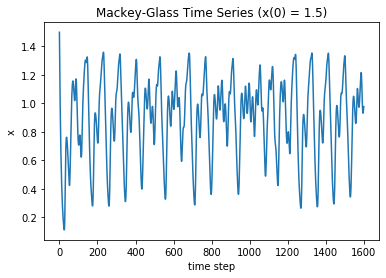

In [121]:
plt.plot(x)
plt.xlabel("time step")
plt.ylabel("x")
plt.title("Mackey-Glass Time Series (x(0) = 1.5)")

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_164 (Dense)            (None, 1)                 11        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 2s 2ms/step - loss: 0.3713 - val_loss: 0.1187
Epoch 2/1000
800/800 [==============================] - 0s 47us/step - loss: 0.0836 - val_loss: 0.0787
Epoch 3/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0598 - val_loss: 0.0770
Epoch 4/1000
800/800 [==============================] - 0s 42us/step - loss: 0.0589 - val_loss: 0.0774
Epoch 5/1000
800/800 [==============================] - 0s 56u

800/800 [==============================] - 0s 33us/step - loss: 0.0050 - val_loss: 0.0071
Epoch 74/1000
800/800 [==============================] - 0s 32us/step - loss: 0.0049 - val_loss: 0.0070
Epoch 75/1000
800/800 [==============================] - 0s 35us/step - loss: 0.0048 - val_loss: 0.0069
Epoch 76/1000
800/800 [==============================] - 0s 30us/step - loss: 0.0047 - val_loss: 0.0070
Epoch 77/1000
800/800 [==============================] - 0s 30us/step - loss: 0.0046 - val_loss: 0.0067
Epoch 78/1000
800/800 [==============================] - 0s 30us/step - loss: 0.0046 - val_loss: 0.0067
Epoch 79/1000
800/800 [==============================] - 0s 39us/step - loss: 0.0045 - val_loss: 0.0066
Epoch 80/1000
800/800 [==============================] - 0s 39us/step - loss: 0.0044 - val_loss: 0.0066
Epoch 81/1000
800/800 [==============================] - 0s 34us/step - loss: 0.0043 - val_loss: 0.0065
Epoch 82/1000
800/800 [==============================] - 0s 32us/step - loss: 

800/800 [==============================] - 0s 55us/step - loss: 0.0021 - val_loss: 0.0037
Epoch 152/1000
800/800 [==============================] - 0s 51us/step - loss: 0.0020 - val_loss: 0.0036
Epoch 153/1000
800/800 [==============================] - 0s 46us/step - loss: 0.0020 - val_loss: 0.0036
Epoch 154/1000
800/800 [==============================] - 0s 31us/step - loss: 0.0020 - val_loss: 0.0036
Epoch 155/1000
800/800 [==============================] - 0s 32us/step - loss: 0.0020 - val_loss: 0.0036
Epoch 156/1000
800/800 [==============================] - 0s 34us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 157/1000
800/800 [==============================] - 0s 29us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 158/1000
800/800 [==============================] - 0s 35us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 159/1000
800/800 [==============================] - 0s 29us/step - loss: 0.0019 - val_loss: 0.0035
Epoch 160/1000
800/800 [==============================] - 0s 31us/step

800/800 [==============================] - 0s 42us/step - loss: 0.0012 - val_loss: 0.0021
Epoch 230/1000
800/800 [==============================] - 0s 40us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 231/1000
800/800 [==============================] - 0s 41us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 232/1000
800/800 [==============================] - 0s 34us/step - loss: 0.0012 - val_loss: 0.0021
Epoch 233/1000
800/800 [==============================] - 0s 32us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 234/1000
800/800 [==============================] - 0s 37us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 235/1000
800/800 [==============================] - 0s 42us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 236/1000
800/800 [==============================] - 0s 44us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 237/1000
800/800 [==============================] - 0s 40us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 238/1000
800/800 [==============================] - 0s 42us/step

800/800 [==============================] - 0s 42us/step - loss: 9.0912e-04 - val_loss: 0.0012
Epoch 307/1000
800/800 [==============================] - 0s 41us/step - loss: 9.0217e-04 - val_loss: 0.0012
Epoch 308/1000
800/800 [==============================] - 0s 40us/step - loss: 9.2125e-04 - val_loss: 0.0012
Epoch 309/1000
800/800 [==============================] - 0s 34us/step - loss: 9.1385e-04 - val_loss: 0.0012
Epoch 310/1000
800/800 [==============================] - 0s 37us/step - loss: 9.0169e-04 - val_loss: 0.0012
Epoch 311/1000
800/800 [==============================] - 0s 42us/step - loss: 8.9747e-04 - val_loss: 0.0012
Epoch 312/1000
800/800 [==============================] - 0s 35us/step - loss: 8.9983e-04 - val_loss: 0.0012
Epoch 313/1000
800/800 [==============================] - 0s 39us/step - loss: 8.8905e-04 - val_loss: 0.0012
Epoch 314/1000
800/800 [==============================] - 0s 30us/step - loss: 8.9599e-04 - val_loss: 0.0012
Epoch 315/1000
800/800 [==========

800/800 [==============================] - 0s 36us/step - loss: 7.9134e-04 - val_loss: 9.0400e-04
Epoch 381/1000
800/800 [==============================] - 0s 37us/step - loss: 7.8728e-04 - val_loss: 9.4862e-04
Epoch 382/1000
800/800 [==============================] - 0s 34us/step - loss: 8.0701e-04 - val_loss: 9.5727e-04
Epoch 383/1000
800/800 [==============================] - 0s 36us/step - loss: 7.8270e-04 - val_loss: 8.9574e-04
Epoch 384/1000
800/800 [==============================] - 0s 40us/step - loss: 7.9019e-04 - val_loss: 9.2006e-04
Epoch 385/1000
800/800 [==============================] - 0s 31us/step - loss: 7.8222e-04 - val_loss: 9.3496e-04
Epoch 386/1000
800/800 [==============================] - 0s 28us/step - loss: 7.8339e-04 - val_loss: 8.9340e-04
Epoch 387/1000
800/800 [==============================] - 0s 32us/step - loss: 7.8285e-04 - val_loss: 8.8868e-04
Epoch 388/1000
800/800 [==============================] - 0s 27us/step - loss: 7.8224e-04 - val_loss: 8.8556e-0

800/800 [==============================] - 0s 39us/step - loss: 7.4684e-04 - val_loss: 8.2770e-04
Epoch 453/1000
800/800 [==============================] - ETA: 0s - loss: 9.0476e-0 - 0s 56us/step - loss: 7.3995e-04 - val_loss: 8.1778e-04
Epoch 454/1000
800/800 [==============================] - 0s 42us/step - loss: 7.3730e-04 - val_loss: 8.6606e-04
Epoch 455/1000
800/800 [==============================] - 0s 52us/step - loss: 7.4907e-04 - val_loss: 8.0181e-04
Epoch 456/1000
800/800 [==============================] - 0s 34us/step - loss: 7.3698e-04 - val_loss: 8.2067e-04
Epoch 457/1000
800/800 [==============================] - 0s 30us/step - loss: 7.3625e-04 - val_loss: 7.9646e-04
Epoch 458/1000
800/800 [==============================] - 0s 29us/step - loss: 7.4237e-04 - val_loss: 8.2397e-04
Epoch 459/1000
800/800 [==============================] - 0s 36us/step - loss: 7.3570e-04 - val_loss: 7.9858e-04
Epoch 460/1000
800/800 [==============================] - 0s 36us/step - loss: 7.32

800/800 [==============================] - 0s 31us/step - loss: 7.1665e-04 - val_loss: 7.6563e-04
Epoch 525/1000
800/800 [==============================] - 0s 29us/step - loss: 7.3167e-04 - val_loss: 7.9420e-04
Epoch 526/1000
800/800 [==============================] - 0s 29us/step - loss: 7.1916e-04 - val_loss: 7.9948e-04
Epoch 527/1000
800/800 [==============================] - 0s 29us/step - loss: 7.0936e-04 - val_loss: 7.6739e-04
Epoch 528/1000
800/800 [==============================] - 0s 27us/step - loss: 7.1200e-04 - val_loss: 8.0530e-04
Epoch 529/1000
800/800 [==============================] - ETA: 0s - loss: 7.5586e-0 - 0s 34us/step - loss: 7.2349e-04 - val_loss: 7.6273e-04
Epoch 530/1000
800/800 [==============================] - 0s 34us/step - loss: 7.2018e-04 - val_loss: 7.6133e-04
Epoch 531/1000
800/800 [==============================] - 0s 31us/step - loss: 7.1245e-04 - val_loss: 7.6024e-04
Epoch 532/1000
800/800 [==============================] - 0s 32us/step - loss: 7.09

800/800 [==============================] - 0s 40us/step - loss: 6.9804e-04 - val_loss: 7.5387e-04
Epoch 597/1000
800/800 [==============================] - 0s 41us/step - loss: 6.9640e-04 - val_loss: 7.4630e-04
Epoch 598/1000
800/800 [==============================] - 0s 36us/step - loss: 6.9206e-04 - val_loss: 7.6561e-04
Epoch 599/1000
800/800 [==============================] - 0s 32us/step - loss: 7.0613e-04 - val_loss: 7.6258e-04
Epoch 600/1000
800/800 [==============================] - 0s 39us/step - loss: 6.9906e-04 - val_loss: 7.3712e-04
Epoch 601/1000
800/800 [==============================] - 0s 40us/step - loss: 7.0631e-04 - val_loss: 7.4151e-04
Epoch 602/1000
800/800 [==============================] - 0s 40us/step - loss: 7.0185e-04 - val_loss: 8.1266e-04
Epoch 603/1000
800/800 [==============================] - 0s 37us/step - loss: 7.0340e-04 - val_loss: 7.4022e-04
Epoch 604/1000
800/800 [==============================] - 0s 35us/step - loss: 6.9426e-04 - val_loss: 7.4405e-0

800/800 [==============================] - 0s 31us/step - loss: 6.9092e-04 - val_loss: 7.6458e-04
Epoch 669/1000
800/800 [==============================] - 0s 34us/step - loss: 6.9281e-04 - val_loss: 7.2628e-04
Epoch 670/1000
800/800 [==============================] - 0s 31us/step - loss: 7.0023e-04 - val_loss: 7.3933e-04
Epoch 671/1000
800/800 [==============================] - 0s 35us/step - loss: 6.8829e-04 - val_loss: 7.5585e-04
Epoch 672/1000
800/800 [==============================] - 0s 37us/step - loss: 6.9083e-04 - val_loss: 7.2201e-04
Epoch 673/1000
800/800 [==============================] - 0s 32us/step - loss: 6.8718e-04 - val_loss: 7.2373e-04
Epoch 674/1000
800/800 [==============================] - 0s 32us/step - loss: 6.9351e-04 - val_loss: 7.2318e-04
Epoch 675/1000
800/800 [==============================] - 0s 35us/step - loss: 6.7961e-04 - val_loss: 7.2068e-04
Epoch 676/1000
800/800 [==============================] - 0s 32us/step - loss: 6.9630e-04 - val_loss: 7.2208e-0

800/800 [==============================] - 0s 31us/step - loss: 6.7916e-04 - val_loss: 7.6892e-04
Epoch 741/1000
800/800 [==============================] - 0s 32us/step - loss: 6.8370e-04 - val_loss: 7.1366e-04
Epoch 742/1000
800/800 [==============================] - 0s 31us/step - loss: 6.8259e-04 - val_loss: 7.0956e-04
Epoch 743/1000
800/800 [==============================] - 0s 30us/step - loss: 6.7743e-04 - val_loss: 7.2849e-04
Epoch 744/1000
800/800 [==============================] - 0s 34us/step - loss: 6.7941e-04 - val_loss: 7.6031e-04
Epoch 745/1000
800/800 [==============================] - 0s 29us/step - loss: 6.7929e-04 - val_loss: 7.0756e-04
Epoch 746/1000
800/800 [==============================] - 0s 34us/step - loss: 6.8457e-04 - val_loss: 7.1485e-04
Epoch 747/1000
800/800 [==============================] - 0s 31us/step - loss: 6.8470e-04 - val_loss: 7.2535e-04
Epoch 748/1000
800/800 [==============================] - 0s 31us/step - loss: 6.7078e-04 - val_loss: 7.0764e-0

800/800 [==============================] - 0s 44us/step - loss: 6.6978e-04 - val_loss: 7.0598e-04
Epoch 813/1000
800/800 [==============================] - 0s 40us/step - loss: 6.7382e-04 - val_loss: 7.2982e-04
Epoch 814/1000
800/800 [==============================] - 0s 44us/step - loss: 6.7184e-04 - val_loss: 7.2546e-04
Epoch 815/1000
800/800 [==============================] - 0s 41us/step - loss: 6.7652e-04 - val_loss: 7.0295e-04
Epoch 816/1000
800/800 [==============================] - 0s 41us/step - loss: 6.6158e-04 - val_loss: 6.9420e-04
Epoch 817/1000
800/800 [==============================] - 0s 41us/step - loss: 6.6853e-04 - val_loss: 6.9480e-04
Epoch 818/1000
800/800 [==============================] - 0s 37us/step - loss: 6.6414e-04 - val_loss: 6.9332e-04
Epoch 819/1000
800/800 [==============================] - 0s 39us/step - loss: 6.6208e-04 - val_loss: 6.9569e-04
Epoch 820/1000
800/800 [==============================] - 0s 39us/step - loss: 6.6735e-04 - val_loss: 7.6026e-0

800/800 [==============================] - 0s 42us/step - loss: 6.6327e-04 - val_loss: 7.1556e-04
Epoch 885/1000
800/800 [==============================] - 0s 42us/step - loss: 6.6232e-04 - val_loss: 7.0343e-04
Epoch 886/1000
800/800 [==============================] - 0s 42us/step - loss: 6.5906e-04 - val_loss: 7.3547e-04
Epoch 887/1000
800/800 [==============================] - 0s 42us/step - loss: 6.6517e-04 - val_loss: 6.9736e-04
Epoch 888/1000
800/800 [==============================] - 0s 36us/step - loss: 6.6800e-04 - val_loss: 6.8698e-04
Epoch 889/1000
800/800 [==============================] - 0s 40us/step - loss: 6.6689e-04 - val_loss: 6.8782e-04
Epoch 890/1000
800/800 [==============================] - 0s 39us/step - loss: 6.6348e-04 - val_loss: 6.8569e-04
Epoch 891/1000
800/800 [==============================] - 0s 37us/step - loss: 6.7046e-04 - val_loss: 6.8309e-04
Epoch 892/1000
800/800 [==============================] - 0s 37us/step - loss: 6.6029e-04 - val_loss: 6.8985e-0

800/800 [==============================] - 0s 40us/step - loss: 6.5414e-04 - val_loss: 6.8714e-04
Epoch 957/1000
800/800 [==============================] - 0s 40us/step - loss: 6.5269e-04 - val_loss: 7.0057e-04
Epoch 958/1000
800/800 [==============================] - 0s 35us/step - loss: 6.6089e-04 - val_loss: 6.7908e-04
Epoch 959/1000
800/800 [==============================] - 0s 35us/step - loss: 6.5824e-04 - val_loss: 6.7455e-04
Epoch 960/1000
800/800 [==============================] - 0s 54us/step - loss: 6.5869e-04 - val_loss: 7.4412e-04
Epoch 961/1000
800/800 [==============================] - 0s 40us/step - loss: 6.6352e-04 - val_loss: 7.0647e-04
Epoch 962/1000
800/800 [==============================] - 0s 42us/step - loss: 6.6723e-04 - val_loss: 6.7987e-04
Epoch 963/1000
800/800 [==============================] - 0s 42us/step - loss: 6.4899e-04 - val_loss: 6.8080e-04
Epoch 964/1000
800/800 [==============================] - 0s 42us/step - loss: 6.7079e-04 - val_loss: 6.8246e-0

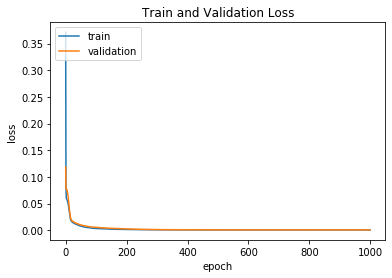

In [175]:



model, es = init_network([10, 1])

history = model.fit(train_set, train_labels, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

MSE: 0.0008007936406092869


Text(0.5, 1.0, 'Mackey-Glass Time Series (x(0) = 1.5)')

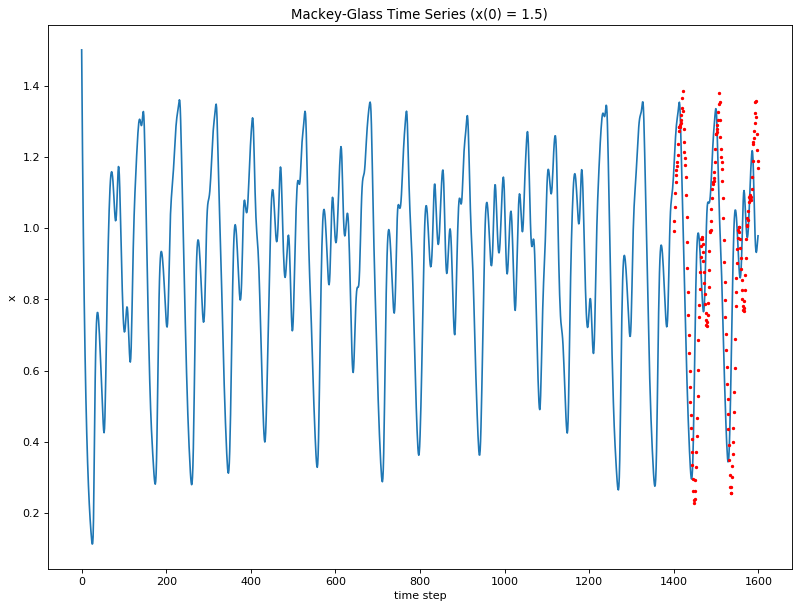

In [176]:
predictions = model.predict(test_set, verbose=0)
print("MSE:",mse(test_labels,predictions))


figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x)
plt.plot(range(1400,1600),predictions,'ro',markersize=2)
plt.xlabel("time step")
plt.ylabel("x")
plt.title("Mackey-Glass Time Series (x(0) = 1.5)")

Text(0.5, 1.0, 'Weight distribution for lambda = 0.01')

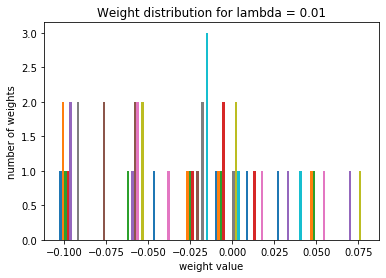

In [170]:
weights, biases = model.layers[0].get_weights()
plt.hist(weights)
plt.xlabel("weight value")
plt.ylabel("number of weights")
plt.title("Weight distribution for lambda = 0.01")

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_356 (Dense)            (None, 5)                 505       
_________________________________________________________________
dense_357 (Dense)            (None, 1)                 6         
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 3s 4ms/step - loss: 0.6690 - val_loss: 0.2033
Epoch 2/1000
800/800 [==============================] - 0s 68us/step - loss: 0.1473 - val_loss: 0.1286
Epoch 3/1000
800/800 [==============================] - 0s 77us/step - loss: 0.1289 - val_loss: 0.1226
Epoch 4/1000
800/800 [====

800/800 [==============================] - 0s 64us/step - loss: 0.1128 - val_loss: 0.1150
Epoch 73/1000
800/800 [==============================] - 0s 70us/step - loss: 0.1126 - val_loss: 0.1142
Epoch 74/1000
800/800 [==============================] - 0s 62us/step - loss: 0.1127 - val_loss: 0.1149
Epoch 75/1000
800/800 [==============================] - 0s 49us/step - loss: 0.1126 - val_loss: 0.1149
Epoch 76/1000
800/800 [==============================] - 0s 47us/step - loss: 0.1126 - val_loss: 0.1149
Epoch 77/1000
800/800 [==============================] - 0s 55us/step - loss: 0.1128 - val_loss: 0.1149
Epoch 78/1000
800/800 [==============================] - 0s 49us/step - loss: 0.1127 - val_loss: 0.1147
Epoch 79/1000
800/800 [==============================] - 0s 57us/step - loss: 0.1127 - val_loss: 0.1156
Epoch 80/1000
800/800 [==============================] - 0s 54us/step - loss: 0.1127 - val_loss: 0.1140
Epoch 81/1000
800/800 [==============================] - 0s 45us/step - loss: 

800/800 [==============================] - 0s 64us/step - loss: 0.1129 - val_loss: 0.1149
Epoch 151/1000
800/800 [==============================] - 0s 69us/step - loss: 0.1129 - val_loss: 0.1145
Epoch 152/1000
800/800 [==============================] - 0s 72us/step - loss: 0.1128 - val_loss: 0.1152
Epoch 153/1000
800/800 [==============================] - 0s 68us/step - loss: 0.1126 - val_loss: 0.1136
Epoch 154/1000
800/800 [==============================] - 0s 59us/step - loss: 0.1129 - val_loss: 0.1153
Epoch 155/1000
800/800 [==============================] - 0s 54us/step - loss: 0.1129 - val_loss: 0.1154
Epoch 156/1000
800/800 [==============================] - 0s 47us/step - loss: 0.1126 - val_loss: 0.1153
Epoch 157/1000
800/800 [==============================] - 0s 54us/step - loss: 0.1126 - val_loss: 0.1147
Epoch 158/1000
800/800 [==============================] - 0s 49us/step - loss: 0.1127 - val_loss: 0.1143
Epoch 159/1000
800/800 [==============================] - 0s 55us/step

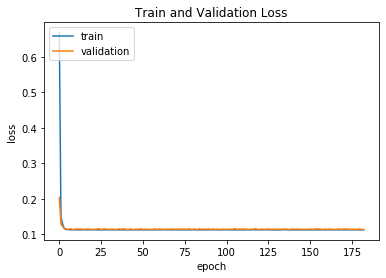

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_358 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_359 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_360 (Dense)            (None, 1)                 11        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 3s 4ms/step - loss: 0.7187 - val_loss: 0.2573
Epoch 2/1000
800/800 [==============================] - 0s 47us/step - loss: 0.1568 - val_loss: 0.1359
Epoch 3/1000
800/800 [==============================] - 0s 50us/step - loss: 0.1318 - val_loss: 0.1252
Epoch 4/1000
800/800 [====

800/800 [==============================] - 0s 65us/step - loss: 0.1128 - val_loss: 0.1150
Epoch 73/1000
800/800 [==============================] - 0s 75us/step - loss: 0.1127 - val_loss: 0.1158
Epoch 74/1000
800/800 [==============================] - 0s 69us/step - loss: 0.1127 - val_loss: 0.1145
Epoch 75/1000
800/800 [==============================] - 0s 64us/step - loss: 0.1127 - val_loss: 0.1141
Epoch 76/1000
800/800 [==============================] - 0s 62us/step - loss: 0.1127 - val_loss: 0.1142
Epoch 77/1000
800/800 [==============================] - 0s 50us/step - loss: 0.1129 - val_loss: 0.1159
Epoch 78/1000
800/800 [==============================] - 0s 48us/step - loss: 0.1125 - val_loss: 0.1137
Epoch 79/1000
800/800 [==============================] - 0s 49us/step - loss: 0.1127 - val_loss: 0.1141
Epoch 80/1000
800/800 [==============================] - 0s 46us/step - loss: 0.1128 - val_loss: 0.1143
Epoch 81/1000
800/800 [==============================] - 0s 46us/step - loss: 

800/800 [==============================] - 0s 61us/step - loss: 0.1126 - val_loss: 0.1145
Epoch 151/1000
800/800 [==============================] - 0s 61us/step - loss: 0.1128 - val_loss: 0.1149
Epoch 152/1000
800/800 [==============================] - 0s 59us/step - loss: 0.1133 - val_loss: 0.1138
Epoch 153/1000
800/800 [==============================] - 0s 54us/step - loss: 0.1129 - val_loss: 0.1161
Epoch 154/1000
800/800 [==============================] - 0s 51us/step - loss: 0.1129 - val_loss: 0.1140
Epoch 155/1000
800/800 [==============================] - 0s 72us/step - loss: 0.1126 - val_loss: 0.1155
Epoch 156/1000
800/800 [==============================] - 0s 107us/step - loss: 0.1127 - val_loss: 0.1146
Epoch 157/1000
800/800 [==============================] - 0s 59us/step - loss: 0.1126 - val_loss: 0.1141
Epoch 158/1000
800/800 [==============================] - 0s 54us/step - loss: 0.1126 - val_loss: 0.1148
Epoch 159/1000
800/800 [==============================] - 0s 50us/ste

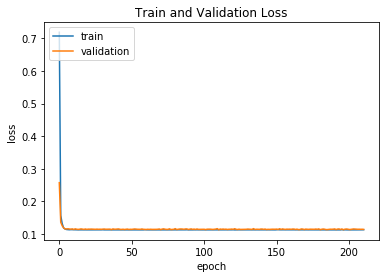

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_361 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_362 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_363 (Dense)            (None, 1)                 21        
Total params: 2,641
Trainable params: 2,641
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 4s 5ms/step - loss: 0.5731 - val_loss: 0.1461
Epoch 2/1000
800/800 [==============================] - 0s 55us/step - loss: 0.1431 - val_loss: 0.1239
Epoch 3/1000
800/800 [==============================] - 0s 49us/step - loss: 0.1222 - val_loss: 0.1249
Epoch 4/1000
800/800 [====

800/800 [==============================] - 0s 106us/step - loss: 0.0549 - val_loss: 0.0457
Epoch 73/1000
800/800 [==============================] - 0s 103us/step - loss: 0.0540 - val_loss: 0.0490
Epoch 74/1000
800/800 [==============================] - 0s 74us/step - loss: 0.0540 - val_loss: 0.0496
Epoch 75/1000
800/800 [==============================] - 0s 71us/step - loss: 0.0536 - val_loss: 0.0460
Epoch 76/1000
800/800 [==============================] - 0s 80us/step - loss: 0.0539 - val_loss: 0.0458
Epoch 77/1000
800/800 [==============================] - 0s 76us/step - loss: 0.0534 - val_loss: 0.0461
Epoch 78/1000
800/800 [==============================] - 0s 65us/step - loss: 0.0529 - val_loss: 0.0472
Epoch 79/1000
800/800 [==============================] - 0s 60us/step - loss: 0.0526 - val_loss: 0.0493
Epoch 80/1000
800/800 [==============================] - 0s 66us/step - loss: 0.0533 - val_loss: 0.0476
Epoch 81/1000
800/800 [==============================] - 0s 60us/step - loss

800/800 [==============================] - 0s 60us/step - loss: 0.0423 - val_loss: 0.0436
Epoch 151/1000
800/800 [==============================] - 0s 64us/step - loss: 0.0429 - val_loss: 0.0451
Epoch 152/1000
800/800 [==============================] - 0s 51us/step - loss: 0.0428 - val_loss: 0.0471
Epoch 153/1000
800/800 [==============================] - 0s 54us/step - loss: 0.0419 - val_loss: 0.0445
Epoch 154/1000
800/800 [==============================] - 0s 60us/step - loss: 0.0422 - val_loss: 0.0447
Epoch 155/1000
800/800 [==============================] - 0s 56us/step - loss: 0.0423 - val_loss: 0.0479
Epoch 156/1000
800/800 [==============================] - 0s 53us/step - loss: 0.0422 - val_loss: 0.0513
Epoch 157/1000
800/800 [==============================] - 0s 52us/step - loss: 0.0421 - val_loss: 0.0455
Epoch 158/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0419 - val_loss: 0.0478
Epoch 159/1000
800/800 [==============================] - 0s 54us/step

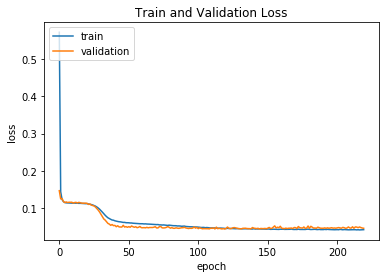

In [212]:
noisy_x = mackey_glass_noisy(0.09)
train_set1, train_labels1, test_set1, test_labels1 = create_datasets(noisy_x)


model1, es = init_network([100, 5, 1], 0.0001)

history = model1.fit(train_set1, train_labels1, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model2, es = init_network([100, 10, 1], 0.0001)

history = model2.fit(train_set1, train_labels1, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model3, es = init_network([100, 20, 1], 0.0001)

history = model3.fit(train_set1, train_labels1, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_367 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_368 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_369 (Dense)            (None, 1)                 51        
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 4s 4ms/step - loss: 0.5240 - val_loss: 0.1362
Epoch 2/1000
800/800 [==============================] - 0s 71us/step - loss: 0.1548 - val_loss: 0.1229
Epoch 3/1000
800/800 [==============================] - 0s 70us/step - loss: 0.1246 - val_loss: 0.1272
Epoch 4/1000
800/800 [====

800/800 [==============================] - 0s 78us/step - loss: 0.0529 - val_loss: 0.0465
Epoch 73/1000
800/800 [==============================] - 0s 59us/step - loss: 0.0525 - val_loss: 0.0461
Epoch 74/1000
800/800 [==============================] - 0s 60us/step - loss: 0.0525 - val_loss: 0.0476
Epoch 75/1000
800/800 [==============================] - 0s 56us/step - loss: 0.0519 - val_loss: 0.0495
Epoch 76/1000
800/800 [==============================] - 0s 60us/step - loss: 0.0517 - val_loss: 0.0478
Epoch 77/1000
800/800 [==============================] - 0s 71us/step - loss: 0.0515 - val_loss: 0.0454
Epoch 78/1000
800/800 [==============================] - 0s 75us/step - loss: 0.0516 - val_loss: 0.0462
Epoch 79/1000
800/800 [==============================] - 0s 74us/step - loss: 0.0513 - val_loss: 0.0462
Epoch 80/1000
800/800 [==============================] - 0s 83us/step - loss: 0.0508 - val_loss: 0.0458
Epoch 81/1000
800/800 [==============================] - 0s 76us/step - loss: 

800/800 [==============================] - 0s 72us/step - loss: 0.0417 - val_loss: 0.0434
Epoch 151/1000
800/800 [==============================] - 0s 77us/step - loss: 0.0416 - val_loss: 0.0445
Epoch 152/1000
800/800 [==============================] - 0s 79us/step - loss: 0.0421 - val_loss: 0.0455
Epoch 153/1000
800/800 [==============================] - 0s 69us/step - loss: 0.0415 - val_loss: 0.0433
Epoch 154/1000
800/800 [==============================] - 0s 66us/step - loss: 0.0416 - val_loss: 0.0453
Epoch 155/1000
800/800 [==============================] - 0s 72us/step - loss: 0.0411 - val_loss: 0.0435
Epoch 156/1000
800/800 [==============================] - 0s 63us/step - loss: 0.0414 - val_loss: 0.0448
Epoch 157/1000
800/800 [==============================] - 0s 62us/step - loss: 0.0411 - val_loss: 0.0452
Epoch 158/1000
800/800 [==============================] - 0s 75us/step - loss: 0.0418 - val_loss: 0.0443
Epoch 159/1000
800/800 [==============================] - 0s 68us/step

800/800 [==============================] - 0s 59us/step - loss: 0.0399 - val_loss: 0.0440
Epoch 229/1000
800/800 [==============================] - 0s 60us/step - loss: 0.0402 - val_loss: 0.0465
Epoch 230/1000
800/800 [==============================] - 0s 58us/step - loss: 0.0399 - val_loss: 0.0469
Epoch 231/1000
800/800 [==============================] - 0s 61us/step - loss: 0.0397 - val_loss: 0.0457
Epoch 232/1000
800/800 [==============================] - 0s 57us/step - loss: 0.0405 - val_loss: 0.0435
Epoch 233/1000
800/800 [==============================] - 0s 59us/step - loss: 0.0396 - val_loss: 0.0438
Epoch 234/1000
800/800 [==============================] - 0s 62us/step - loss: 0.0396 - val_loss: 0.0435
Epoch 235/1000
800/800 [==============================] - 0s 57us/step - loss: 0.0398 - val_loss: 0.0435
Epoch 236/1000
800/800 [==============================] - 0s 55us/step - loss: 0.0391 - val_loss: 0.0468
Epoch 237/1000
800/800 [==============================] - 0s 64us/step

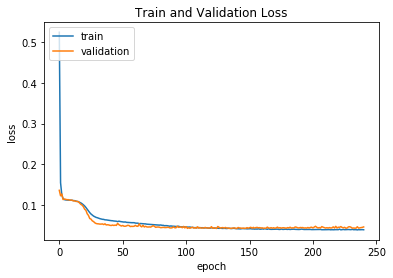

In [214]:
model4, es = init_network([100, 50, 1], 0.0001)

history = model4.fit(train_set1, train_labels1, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [218]:
model, es = init_network([100, 1],0.0001)

history = model.fit(train_set1, train_labels1, epochs=1000, batch_size=50, validation_split=0.2,  callbacks=[es], verbose=1)

predictions0 = model.predict(test_set1, verbose=0)
print("MSE:",mse(test_labels1,predictions0))

predictions1 = model1.predict(test_set1, verbose=0)
print("MSE:",mse(test_labels1,predictions1))

predictions2 = model2.predict(test_set1, verbose=0)
print("MSE:",mse(test_labels1,predictions2))

predictions3 = model3.predict(test_set1, verbose=0)
print("MSE:",mse(test_labels1,predictions3))

predictions4 = model4.predict(test_set1, verbose=0)
print("MSE:",mse(test_labels1,predictions4))

Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_376 (Dense)            (None, 100)               600       
_________________________________________________________________
dense_377 (Dense)            (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 3s 4ms/step - loss: 0.3426 - val_loss: 0.1342
Epoch 2/1000
800/800 [==============================] - 0s 57us/step - loss: 0.1175 - val_loss: 0.1062
Epoch 3/1000
800/800 [==============================] - 0s 59us/step - loss: 0.0992 - val_loss: 0.0850
Epoch 4/1000
800/800 [==============================] - 0s 58us/step - loss: 0.0889 - val_loss: 0.0740
Epoch 5/1000
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 56us/step - loss: 0.0502 - val_loss: 0.0422
Epoch 74/1000
800/800 [==============================] - 0s 52us/step - loss: 0.0503 - val_loss: 0.0425
Epoch 75/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0499 - val_loss: 0.0431
Epoch 76/1000
800/800 [==============================] - 0s 54us/step - loss: 0.0498 - val_loss: 0.0438
Epoch 77/1000
800/800 [==============================] - 0s 61us/step - loss: 0.0498 - val_loss: 0.0422
Epoch 78/1000
800/800 [==============================] - 0s 57us/step - loss: 0.0496 - val_loss: 0.0435
Epoch 79/1000
800/800 [==============================] - 0s 52us/step - loss: 0.0497 - val_loss: 0.0437
Epoch 80/1000
800/800 [==============================] - 0s 52us/step - loss: 0.0491 - val_loss: 0.0442
Epoch 81/1000
800/800 [==============================] - 0s 54us/step - loss: 0.0488 - val_loss: 0.0443
Epoch 82/1000
800/800 [==============================] - 0s 47us/step - loss: 

Epoch 151/1000
800/800 [==============================] - 0s 47us/step - loss: 0.0422 - val_loss: 0.0410
Epoch 152/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0421 - val_loss: 0.0411
Epoch 153/1000
800/800 [==============================] - 0s 55us/step - loss: 0.0426 - val_loss: 0.0409
Epoch 154/1000
800/800 [==============================] - 0s 46us/step - loss: 0.0427 - val_loss: 0.0414
Epoch 155/1000
800/800 [==============================] - 0s 49us/step - loss: 0.0428 - val_loss: 0.0427
Epoch 156/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0422 - val_loss: 0.0414
Epoch 157/1000
800/800 [==============================] - 0s 54us/step - loss: 0.0424 - val_loss: 0.0412
Epoch 158/1000
800/800 [==============================] - 0s 55us/step - loss: 0.0419 - val_loss: 0.0417
Epoch 159/1000
800/800 [==============================] - 0s 50us/step - loss: 0.0418 - val_loss: 0.0420
Epoch 160/1000
800/800 [==============================]